In [70]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from sklearn import preprocessing
from IPython.display import display

In [71]:
%matplotlib inline
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [137]:
# import csv file
df = pd.read_csv('2014_NEW_YORK_Offenses_Known_to_Law_Enforcement.csv')
#df = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master' +
#                 '/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv')


# clean up the dataframe
df = df.drop([0,1,2])
df = df.rename(columns=df.iloc[0])
df = df.rename(columns = {'Murder and\nnonnegligent\nmanslaughter':'Murder',
                          'Aggravated\nassault':'Aggravated_Assault',
                          'Property\ncrime':'Property_Crime',
                          'Larceny-\ntheft':'Larceny_Theft',
                          'Motor\nvehicle\ntheft':'Motor_Theft',
                          'Arson3': 'Arson'})
df = df.drop([3])
df = df.reset_index(drop = True)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

In [138]:
# Change Population from object to int
df['Population'] = df['Population'].str.replace(',', '')
df['Population'] = pd.to_numeric(df['Population']).astype(float)

# Set up 'Murder', 'Robbery' and 'Property Crime' for later use
df['Murder'] = df['Murder'].str.replace(',', '')
df['Robbery'] = df['Robbery'].str.replace(',', '')

df['Aggravated_Assault'] = df['Aggravated_Assault'].str.replace(',', '')
df['Aggravated_Assault'] = pd.to_numeric(df['Aggravated_Assault']).astype(float)

df['Burglary'] = df['Burglary'].str.replace(',', '')
df['Burglary'] = pd.to_numeric(df['Burglary']).astype(float)

df['Larceny_Theft'] = df['Larceny_Theft'].str.replace(',', '')
df['Larceny_Theft'] = pd.to_numeric(df['Larceny_Theft']).astype(float)

df['Arson'] = df['Arson'].str.replace(',', '')
df['Arson'] = pd.to_numeric(df['Arson']).astype(float)

df['Property_Crime'] = df['Property_Crime'].str.replace(',', '')
df['Property_Crime'] = pd.to_numeric(df['Property_Crime']).astype(float)

df.head()

,City,Population,Violent crime,Murder,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Theft,Arson
0,Adams Village,1851.0,0,0,NaN,0,0,0.0,11.0,1.0,10.0,0,0.0
1,Addison Town and Village,2568.0,2,0,NaN,0,1,1.0,49.0,1.0,47.0,1,0.0
2,Afton Village4,820.0,0,0,0,NaN,0,0.0,1.0,0.0,1.0,0,0.0
3,Akron Village,2842.0,1,0,NaN,0,0,1.0,17.0,0.0,17.0,0,0.0
4,Albany4,98595.0,802,8,54,NaN,237,503.0,3888.0,683.0,3083.0,122,12.0


In [139]:
# Create a Feature dataframe
features = pd.DataFrame()

# set 'Population' and 'Population^2' as feature
## in feature, the values will be in thousands
features['Population'] = (df['Population']).dropna()
features['Population_Squared'] = features['Population']**2

# set 'Murder' and 'Robbery' as feature
# coded any number > 0 as 1
# coded any number = 0 as 0
features['Murder'] = df['Murder'].dropna()
features['Murder'] = features['Murder'].str.contains('0').apply(lambda x:0 if x else 1)

features['Robbery'] = df['Robbery'].dropna()
features['Robbery'] = features['Robbery'].str.contains('0').apply(lambda x:0 if x else 1)

features['Aggravated_Assault'] = df['Aggravated_Assault'].dropna()
features['Burglary'] = df['Burglary'].dropna()
features['Larceny_Theft'] = df['Larceny_Theft'].dropna()
features['Arson'] = df['Arson'].dropna()

# add 'Property Crime' as targeted variable in feature dataframe
features['Property_Crime'] = df['Property_Crime']

features.head()
print(len(features))

369


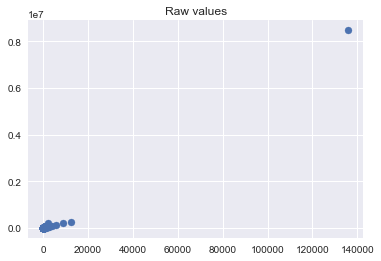

In [140]:
# Instantiate our model.
regr = linear_model.LinearRegression()
Y = features['Property_Crime'].values.reshape(-1, 1)
X = features[['Population', 'Population_Squared', 'Murder', 'Robbery',
              'Aggravated_Assault', 'Burglary', 'Larceny_Theft', 'Arson']]

# Plot scatter graph to identify outliers
plt.scatter(Y, X['Population'])
plt.title('Raw values')
plt.show()

In [141]:
# Remove the outlier
loc = features.loc[lambda x: features['Population'] == features['Population'].max()]
print(loc)
features = features.drop(loc.index)

     Population  Population_Squared  Murder  Robbery  Aggravated_Assault  \
227   8473938.0        7.180763e+13       1        1             31460.0   

     Burglary  Larceny_Theft  Arson  Property_Crime  
227   15916.0       112107.0    NaN        135747.0  


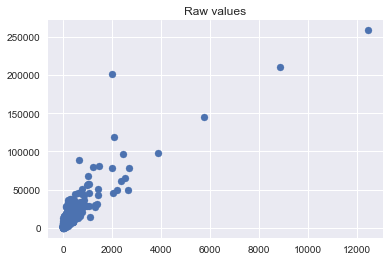

In [142]:
# Instantiate our model.
regr = linear_model.LinearRegression()
Y = features['Property_Crime'].values.reshape(-1, 1)
X = features[['Population', 'Population_Squared', 'Murder', 'Robbery',
              'Aggravated_Assault', 'Burglary', 'Larceny_Theft', 'Arson']]

# Re-Plot scatter graph to identify outliers
plt.scatter(Y, X['Population'])
plt.title('Raw values')
plt.show()

    Want to keep the dataset within 
        Property Crime = 4000 and Population = 100000
        in order to get rid of more outliers        

In [143]:
# Remove the outlier on the y-axis
loc = features.loc[lambda x: features['Population'] > 100000]
print(loc)
features = features.drop(loc.index)

     Population  Population_Squared  Murder  Robbery  Aggravated_Assault  \
9      118860.0        1.412770e+10       1        1                68.0   
38     258419.0        6.678038e+10       0        1              1663.0   
283    210347.0        4.424586e+10       1        1               850.0   
326    144534.0        2.089008e+10       0        0               668.0   
366    200624.0        4.024999e+10       1        1               580.0   

     Burglary  Larceny_Theft  Arson  Property_Crime  
9       176.0         1846.0    2.0          2066.0  
38     3119.0         8362.0    NaN         12449.0  
283    2125.0         6058.0  135.0          8856.0  
326    1404.0         3986.0   57.0          5755.0  
366     414.0         1395.0   15.0          2009.0  


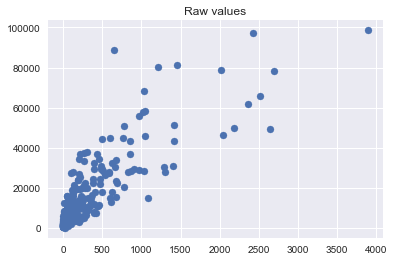

In [144]:
# Remove null values
features = features.dropna()

# Instantiate our model.
regr = linear_model.LinearRegression()
Y = features['Property_Crime'].values.reshape(-1, 1)
X = features[['Population', 'Population_Squared', 'Murder', 'Robbery', 'Aggravated_Assault', 'Burglary', 'Larceny_Theft', 'Arson']]

# Re-Plot scatter graph to identify outliers
plt.scatter(Y, X['Population'])
plt.title('Raw values')
plt.show()

In [145]:
# Fit the data into a model
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  3.24554351e-04   4.50542400e-11   5.54939303e-01  -1.74080515e+00
    1.65595178e-01   1.10145765e+00   9.92842923e-01  -2.00439079e-01]]

Intercept: 
 [-0.93046604]

R-squared:
0.999727015732


,Population,Population_Squared,Murder,Robbery,Aggravated_Assault,Burglary,Larceny_Theft,Arson
Population,1.000000,0.921278,0.560942,0.446352,0.634527,0.723548,0.850718,0.503494
Population_Squared,0.921278,1.000000,0.484174,0.286194,0.629204,0.682941,0.821406,0.434528
Murder,0.560942,0.484174,1.000000,0.270912,0.547073,0.582774,0.571495,0.456012
Robbery,0.446352,0.286194,0.270912,1.000000,0.249712,0.329743,0.392812,0.247426
Aggravated_Assault,0.634527,0.629204,0.547073,0.249712,1.000000,0.913009,0.750749,0.704053
Burglary,0.723548,0.682941,0.582774,0.329743,0.913009,1.000000,0.876253,0.776501
Larceny_Theft,0.850718,0.821406,0.571495,0.392812,0.750749,0.876253,1.000000,0.627176
Arson,0.503494,0.434528,0.456012,0.247426,0.704053,0.776501,0.627176,1.000000


<function matplotlib.pyplot.show>

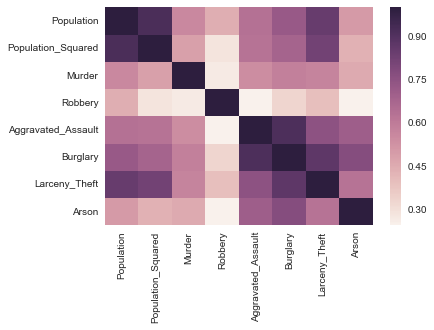

In [146]:
correlation_matrix = X.corr()
display(correlation_matrix)

# show heatmap
sns.heatmap(correlation_matrix)
plt.show

In [148]:
## Benchmark model

# Reinstantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['Property_Crime'].values.reshape(-1, 1)
X = features[['Population_Squared', 'Murder', 'Robbery',
              'Aggravated_Assault', 'Arson']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)  
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  1.82052522e-07   1.08366589e+02   1.00938190e+02   2.84499618e+00
    3.74338231e+01]]

Intercept: 
 [ 27.26569337]

R-squared:
0.84249389735


    Want to add features to the linear formula to compare to the model above. Higher R-Square = better model

,Population_Squared,Murder,Robbery,Aggravated_Assault,Arson
Population_Squared,1.000000,0.484174,0.286194,0.629204,0.434528
Murder,0.484174,1.000000,0.270912,0.547073,0.456012
Robbery,0.286194,0.270912,1.000000,0.249712,0.247426
Aggravated_Assault,0.629204,0.547073,0.249712,1.000000,0.704053
Arson,0.434528,0.456012,0.247426,0.704053,1.000000


<function matplotlib.pyplot.show>

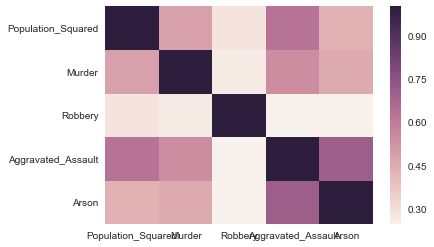

In [155]:
correlation_matrix = X.corr()
display(correlation_matrix)

# show heatmap
sns.heatmap(correlation_matrix)
plt.show

In [149]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Property_Crime ~ Population_Squared + Murder + Robbery + Aggravated_Assault + Arson'

# Fit the model to our data using the formula.
lm = smf.ols(formula = linear_formula, data = features).fit()

In [150]:
# list the parameters
lm.params

Intercept             2.726569e+01
Population_Squared    1.820525e-07
Murder                1.083666e+02
Robbery               1.009382e+02
Aggravated_Assault    2.844996e+00
Arson                 3.743382e+01
dtype: float64

In [151]:
# list the p-values
lm.pvalues

Intercept             5.425813e-02
Population_Squared    1.980991e-46
Murder                3.643348e-03
Robbery               2.142953e-06
Aggravated_Assault    1.281012e-16
Arson                 7.187192e-10
dtype: float64

In [152]:
# Calculate the R-Square
lm.rsquared

0.84249389735023095

    From LinearRegression(), same R-squared value
    R-squared: 0.725895265569

In [153]:
# Find Confidence Interval
# Column '0' is the lower bound of the 95% confidence interval and column '1' is the upper bound
lm.conf_int()

,0,1
Intercept,-5.012345e-01,5.503262e+01
Population_Squared,1.605640e-07,2.035410e-07
Murder,3.555441e+01,1.811788e+02
Robbery,5.974532e+01,1.421311e+02
Aggravated_Assault,2.201779e+00,3.488214e+00
Arson,2.581361e+01,4.905404e+01


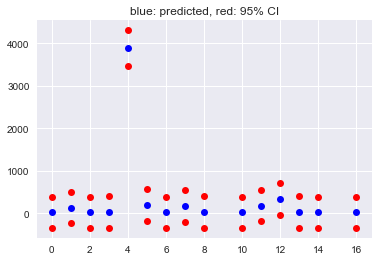

In [154]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

    Normalize the features and run the model again
    * run histogram and then use z-normalization
    * set the outliers to largest value in normalized data
    # There are also few more outliers, will need to remove them or adjust their values for more accurate model

In [156]:
features.head()

,Population,Population_Squared,Murder,Robbery,Aggravated_Assault,Burglary,Larceny_Theft,Arson,Property_Crime
0,1851.0,3.426201e+06,0,0,0.0,1.0,10.0,0.0,11.0
1,2568.0,6.594624e+06,0,1,1.0,1.0,47.0,0.0,49.0
2,820.0,6.724000e+05,0,0,0.0,0.0,1.0,0.0,1.0
3,2842.0,8.076964e+06,0,0,1.0,0.0,17.0,0.0,17.0
4,98595.0,9.720974e+09,1,1,503.0,683.0,3083.0,12.0,3888.0


In [157]:
# min max scaler
min_max_scaler = preprocessing.MinMaxScaler()
features_scaled = min_max_scaler.fit_transform(features)
features_normalized = pd.DataFrame(features_scaled)
features_normalized.head()

,0,1,2,3,4,5,6,7,8
0,0.017987,0.000352,0.0,0.0,0.000000,0.001464,0.003244,0.000000,0.002829
1,0.025265,0.000678,0.0,1.0,0.001988,0.001464,0.015245,0.000000,0.012603
2,0.007522,0.000069,0.0,0.0,0.000000,0.000000,0.000324,0.000000,0.000257
3,0.028046,0.000830,0.0,0.0,0.001988,0.000000,0.005514,0.000000,0.004372
4,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.631579,1.000000
